# Imports

In [89]:
import gzip
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
mpl.rcParams['image.cmap'] = 'gray'

In [29]:
def test(a, b, cmp, cname=None):
    if cname is None:
        cname = cmp.__name__
    assert cmp(a, b), f'{cname}:\n{a}\n{b}'

def near(a, b):
    torch.allclose(a, b, atol=1e-5, rtol=1e-3)
    
def test_near(a, b):
    return test(a, b, near)

# Data

In [3]:
DATA_PATH = Path('/Users/imad/.fastai/data/')
!ls {DATA_PATH}

mnist.pkl.gz


In [4]:
FILE_NAME = 'mnist.pkl.gz'

In [5]:
with gzip.open(DATA_PATH / FILE_NAME, 'rb') as f:
    (X_train, y_train), (X_valid, y_valid), _ = pickle.load(f, encoding='latin-1')
    X_train, y_train, X_valid, y_valid = map(torch.tensor, (X_train, y_train, X_valid, y_valid))
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

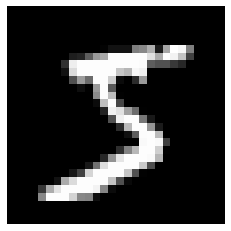

In [11]:
plt.imshow(X_train[0].view(28, 28))
plt.axis('off');

# Initial Model

In [23]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [24]:
y_train.max(), y_train.min()

(tensor(9), tensor(0))

In [25]:
n_in = X_train.shape[1]
n_out = y_train.max().item() + 1
nh = 50
n_in, nh, n_out

(784, 50, 10)

In [26]:
model = Model(n_in, nh, n_out)
model

Model()

In [27]:
def log_softmax(x):
    return (x.exp() / x.exp().sum(dim=-1, keepdim=True)).log()

In [28]:
def nll(pred, target):
    return -pred[torch.arange(len(pred)), target].mean()

In [30]:
preds = model(X_train)

In [31]:
nn.CrossEntropyLoss()(preds, y_train)

tensor(2.2983, grad_fn=<NllLossBackward>)

In [32]:
nll(log_softmax(preds), y_train)

tensor(2.2983, grad_fn=<NegBackward>)

In [34]:
test_near(nn.CrossEntropyLoss()(preds, y_train), nll(log_softmax(preds), y_train))

AssertionError: near:
2.2982726097106934
2.2982900142669678

In [40]:
preds.max(dim=-1)[0]

tensor([0.1795, 0.2057, 0.2219,  ..., 0.1697, 0.1851, 0.1985],
       grad_fn=<MaxBackward0>)

In [41]:
def logsumexp(x):
    m = x.max(dim=-1)[0]
    return m + (x - m[..., None]).exp().sum(dim=-1).log()

In [43]:
test_near(logsumexp(preds), preds.logsumexp(-1))

AssertionError: near:
tensor([2.3708, 2.3508, 2.3489,  ..., 2.3460, 2.3746, 2.3631],
       grad_fn=<AddBackward0>)
tensor([2.3708, 2.3508, 2.3489,  ..., 2.3460, 2.3746, 2.3631],
       grad_fn=<LogsumexpBackward>)

In [44]:
def log_softmax(x):
    return x - x.logsumexp(dim=-1, keepdim=True)

In [45]:
def accuracy(preds, target):
    return (torch.argmax(preds, dim=1) == target).float().mean()

# Basic Training Loop 

In [47]:
class Sequential(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [48]:
model = Sequential([nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)])
model

Sequential(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [50]:
model = nn.Sequential(nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [51]:
class Optimizer:
    def __init__(self, parameters, lr):
        self.parameters = list(parameters)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for param in self.parameters:
                param -= self.lr * param.grad
    
    def zero_grad(self):
        for param in self.parameters:
            param.grad.data.zero_()

In [55]:
list(zip(*[(1, 2), (3, 4), (5, 6)]))

[(1, 3, 5), (2, 4, 6)]

In [56]:
class Dataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [67]:
class DataLoader:
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
        self.n = len(self.ds)

    def __iter__(self):
        for i in range(0, self.n, self.bs):
            yield self.ds[i:i + self.bs]

In [68]:
train_ds = Dataset(X_train, y_train)
train_dl = DataLoader(train_ds, 10)

In [69]:
next(iter(train_dl))

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4]))

In [70]:
class Sampler:
    def __init__(self, ds, bs, shuffle=True):
        self.bs = bs
        self.shuffle = shuffle
        self.n = len(ds)

    def __iter__(self):
        idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs):
            yield idxs[i:i + self.bs]

In [ ]:
torch.utils.data.DataLoader()

In [74]:
def collate(batch):
    xb, yb = zip(*batch)
    return torch.stack(xb), torch.stack(yb)


class DataLoader:
    def __init__(self, ds, sampler, collate_fn):
        self.ds = ds
        self.sampler = sampler
        self.collate_fn = collate_fn

    def __iter__(self):
        for s in self.sampler:
            yield self.collate_fn([self.ds[i] for i in s])

In [76]:
sampler = Sampler(train_ds, bs=10, shuffle=True)
train_dl = DataLoader(train_ds, sampler, collate)

In [77]:
next(iter(train_dl))

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([7, 4, 3, 7, 9, 8, 6, 8, 1, 5]))

In [80]:
xs, ys = zip(*[train_ds[i] for i in range(10)])

In [85]:
xs[0].shape, len(xs)

(torch.Size([784]), 10)

In [86]:
a, b = zip(*[(1, 2), (3, 4), (5, 6)])

# Callbacks

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as opt

In [102]:
class Dataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [103]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    '''Returns training and validation data loaders.'''
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs * 2, shuffle=False, **kwargs))

In [145]:
class DataBunch:
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.c = c
    
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    @property
    def valid_ds(self):
        return self.valid_dl.dataset

In [146]:
def get_model(data, lr, nh):
    '''Returns model and optimizer.'''
    n_in = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(n_in, nh), nn.ReLU(),
                          nn.Linear(nh, data.c))
    optimizer = opt.SGD(model.parameters(), lr=lr)
    return model, optimizer

In [147]:
class Learner:
    '''Object that stores model, optimizer, loss function, and data.'''
    def __init__(self, model, opt, loss_fn, data):
        self.model = model
        self.opt = opt
        self.loss_fn = loss_fn
        self.data = data

In [148]:
def accuracy(preds, target):
    return (torch.argmax(preds, dim=1) == target).float().mean()

In [149]:
train_ds = Dataset(X_train, y_train)
valid_ds = Dataset(X_valid, y_valid)
len(train_ds), len(valid_ds)

(50000, 10000)

In [150]:
bs = 64
nh = 50
c = y_train.max().item() + 1
c

10

In [151]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c=c)
data.c

10

In [152]:
learner = Learner(*get_model(data, nh=nh, lr=0.5), F.cross_entropy, data)

In [157]:
def fit(epochs, learner):
    '''Fit learner.model'''
    for epoch in range(epochs):
        learner.model.train()
        for xb, yb in learner.data.train_dl:
            preds = learner.model(xb)
            loss = learner.loss_fn(preds, yb)
            loss.backward()
            learner.opt.step()
            learner.opt.zero_grad()

        learner.model.eval()
        with torch.no_grad():
            tot_acc, tot_loss = 0., 0.
            for xb, yb in learner.data.valid_dl:
                preds = learner.model(xb)
                loss = learner.loss_fn(preds, yb)
                tot_acc += (accuracy(preds, yb) * len(xb))
                tot_loss += (loss * len(xb))
        n_valid = len(learner.data.valid_ds)
        print(
            f'Epoch {epoch} : Loss = {tot_loss / n_valid:.2}, Accuracy = {tot_acc / n_valid:.2%}'
        )

In [158]:
fit(2, learner)

Epoch 0 : Loss = 0.13, Accuracy = 96.59%
Epoch 1 : Loss = 0.11, Accuracy = 97.06%


All __callbacks__ should subclass from `Callback` class. They would change the behavior of one or more methods according to their use case.

In [178]:
class Callback():
    '''Main class that all callbacks should subclass from'''
    def begin_fit(self, learn):
        self.learn = learn
        return True

    def after_fit(self):
        return True

    def begin_epoch(self, epoch):
        self.epoch = epoch
        return True

    def begin_validate(self):
        return True

    def after_epoch(self):
        return True

    def begin_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        return True

    def after_loss(self, loss):
        self.loss = loss
        return True

    def after_backward(self):
        return True

    def after_step(self):
        return True

We need a callback handler that can manage all callback and has access to learner to change states.

In [186]:
class CallbackHandler():
    def __init__(self, cbs=None):
        self.cbs = cbs if cbs else []

    def begin_fit(self, learner):
        self.learner = learner
        self.in_train = True
        learner.stop = False
        res = True
        for cb in self.cbs:
            res = res and cb.begin_fit(learner)
        return res

    def after_fit(self):
        res = not self.in_train
        for cb in self.cbs:
            res = res and cb.after_fit()
        return res

    def begin_epoch(self, epoch):
        self.learner.model.train()
        self.in_train = True
        res = True
        for cb in self.cbs:
            res = res and cb.begin_epoch(epoch)
        return res

    def begin_validate(self):
        self.learner.model.eval()
        self.in_train = False
        res = True
        for cb in self.cbs:
            res = res and cb.begin_validate()
        return res

    def after_epoch(self):
        res = True
        for cb in self.cbs:
            res = res and cb.after_epoch()
        return res

    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs:
            res = res and cb.begin_batch(xb, yb)
        return res

    def after_loss(self, loss):
        res = self.in_train
        for cb in self.cbs:
            res = res and cb.after_loss(loss)
        return res

    def after_backward(self):
        res = True
        for cb in self.cbs:
            res = res and cb.after_backward()
        return res

    def after_step(self):
        res = True
        for cb in self.cbs:
            res = res and cb.after_step()
        return res

    def do_stop(self):
        try:
            return self.learner.stop
        finally:
            self.learner.stop = False

In [187]:
def one_batch(xb, yb, cb):
    '''One training batch.'''
    if not cb.begin_batch(xb, yb):
        return
    loss = cb.learner.loss_fn(cb.learner.model(xb), yb)

    if not cb.after_loss(loss):
        return
    loss.backward()

    if cb.after_backward():
        cb.learner.opt.step()

    if cb.after_step():
        cb.learner.opt.zero_grad()

In [188]:
def all_batches(dl, cb):
    '''Performs 1 epoch'''
    for xb, yb in dl:
        one_batch(xb, yb, cb)
        if cb.do_stop():
            return

In [189]:
def fit(epochs, learner, cb):
    '''Complete training loops.'''
    if not cb.begin_fit(learner):
        return
    
    for epoch in range(epochs):
        if not cb.begin_epoch(epoch):
            continue
        all_batches(learner.data.train_dl, cb)
        
        if cb.begin_validate():
            with torch.no_grad():
                all_batches(learner.data.valid_dl, cb)
        
        if cb.do_stop() or not cb.after_epoch():
            break
    cb.after_fit()

In [196]:
# Example of callback that stops after some given number of iterations
class TestCallback(Callback):
    def begin_fit(self, learner):
        super().begin_fit(learner)
        self.n_iter = 0
        return True
    
    def after_step(self):
        self.n_iter += 1
        print(self.n_iter)
        if self.n_iter >= 10:
            learner.stop = True
        return True

In [197]:
fit(1, learner, CallbackHandler([TestCallback()]))

1
2
3
4
5
6
7
8
9
10


In [202]:
model, optimizer = get_model(data, 0.5, nh)